<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj23-cv-chest-x-ray-images-pneumonia?scriptVersionId=193802933" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>Chest X-Ray Images (Pneumonia)</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

This project centers around the classification of chest X-ray images to distinguish between cases of pneumonia and normal, healthy lungs. Utilizing deep learning and computer vision techniques, the aim is to develop a model capable of accurately identifying pneumonia from X-ray images, providing an essential tool for medical diagnostics.

# **Import Libraries and Data**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121, Xception

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100%|██████████████████████████████████████▉| 2.29G/2.29G [00:13<00:00, 192MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:13<00:00, 179MB/s]


# **Data Preparation**
----

In [4]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False,
        rotation_range = 30, 
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False,
        rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    'chest_xray/val',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# **Data Exploration**
----

In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Classes present in datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Classes present in datasets

0 : NORMAL
1 : PNEUMONIA


In [7]:
train_class_counts = dict(zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes)))

print("Number of samples in each class (Training set):")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")


val_class_counts = dict(zip(val_generator.class_indices.keys(), np.bincount(val_generator.classes)))

print("\nNumber of samples in each class (Validation set):")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count}")


test_class_counts = dict(zip(test_generator.class_indices.keys(), np.bincount(test_generator.classes)))

print("\nNumber of samples in each class (Test set):")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")


Number of samples in each class (Training set):
NORMAL: 1341
PNEUMONIA: 3875

Number of samples in each class (Validation set):
NORMAL: 234
PNEUMONIA: 390

Number of samples in each class (Test set):
NORMAL: 8
PNEUMONIA: 8


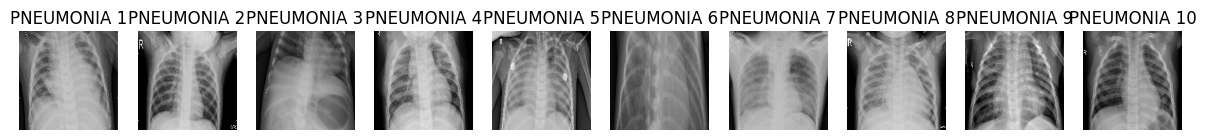

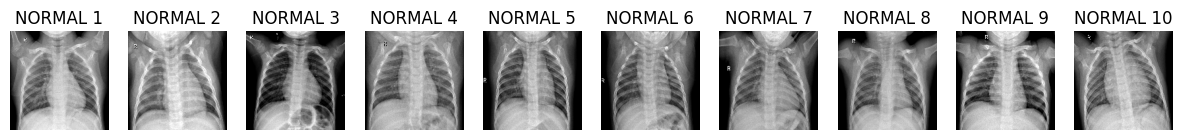

In [8]:
def display_images_by_class(parent_folder, n_images=10):
    class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

    for class_folder in class_folders:
        class_path = os.path.join(parent_folder, class_folder)
        images = os.listdir(class_path)[:n_images]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(150, 150))
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"{class_folder} {i+1}")
            plt.axis('off')
        plt.show()

parent_folder = 'chest_xray/train'

display_images_by_class(parent_folder, n_images=10)

# **Modeling**
----

In [9]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [10]:
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Dropout(0.45)) 
model.add(Dense(220, activation='relu'))
model.add(Dropout(0.25)) 
model.add(Dense(60,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [13]:
history = model.fit(train_generator,epochs=20,validation_data=val_generator, callbacks=[ES,RL],class_weight=class_weights)

Epoch 1/20


I0000 00:00:1724463557.087964     102 service.cc:145] XLA service 0x7e10b4005140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724463557.088048     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/163 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.7031 - loss: 1.0842 

I0000 00:00:1724463566.932435     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 720ms/step - accuracy: 0.8594 - loss: 0.3307 - val_accuracy: 0.8205 - val_loss: 0.4107 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 678ms/step - accuracy: 0.9013 - loss: 0.2281 - val_accuracy: 0.8429 - val_loss: 0.4334 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 671ms/step - accuracy: 0.9195 - loss: 0.1922 - val_accuracy: 0.8654 - val_loss: 0.3690 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 662ms/step - accuracy: 0.9172 - loss: 0.1838 - val_accuracy: 0.8606 - val_loss: 0.4217 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 671ms/step - accuracy: 0.9249 - loss: 0.1703 - val_accuracy: 0.8958 - val_loss: 0.3064 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 665ms/step - accuracy: 0.9287 - loss: 0.1658 - val_accuracy: 0.8798 - val_loss: 0.4137 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 667ms/step - accuracy: 0.9279 

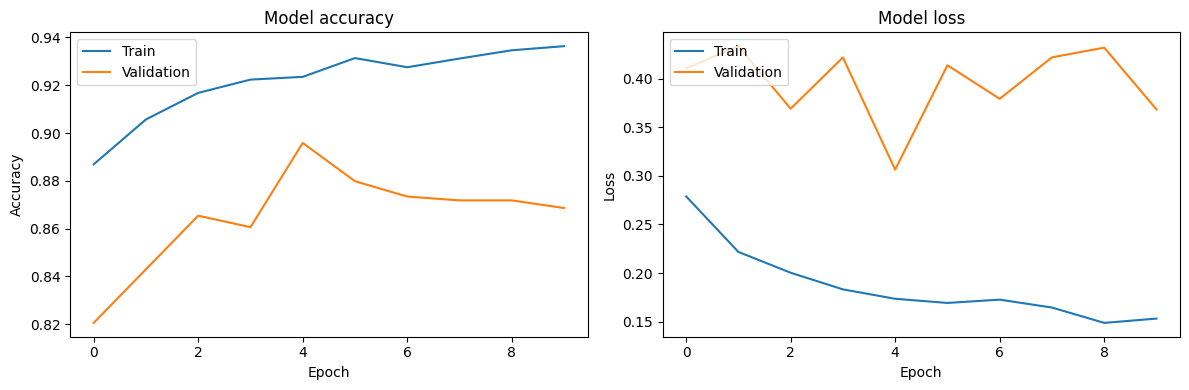

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# **Prediction**
----

In [15]:
loss,acc = model.evaluate(train_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss,acc = model.evaluate(test_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

The accuracy of the model for training data is: 93.61580014228821
The Loss of the model for training data is: 0.15737222135066986
The accuracy of the model for test data is: 75.0
The Loss of the model for test data is: 0.37862181663513184


In [16]:
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


**Confusion Matrix**

In [17]:
predictions = model.predict(test_generator)
predictions = predictions.reshape(1,-1)[0]
cf_mtx = confusion_matrix(y_true,y_pred)
print(cf_mtx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
[[7 1]
 [3 5]]


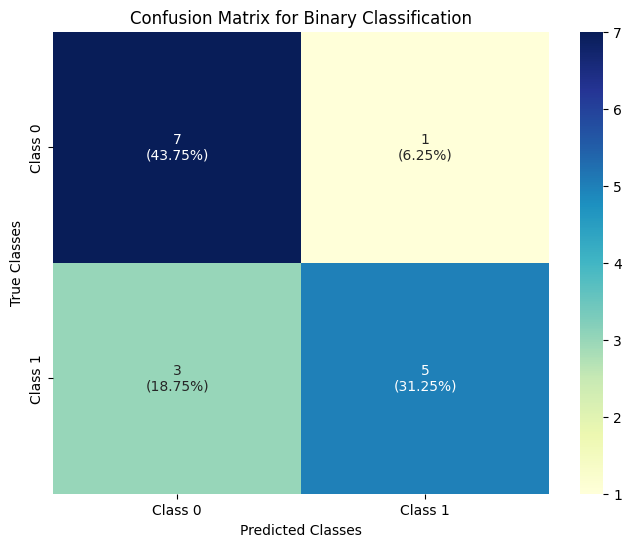

In [18]:
# Calculate the counts and percentages
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_mtx, annot=box_labels, fmt="", cmap="YlGnBu",
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])

plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix for Binary Classification')
plt.show()


**Classification Report**

In [19]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

      NORMAL       0.70      0.88      0.78         8
   PNEUMONIA       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16



**Display Some Images With Predictions**

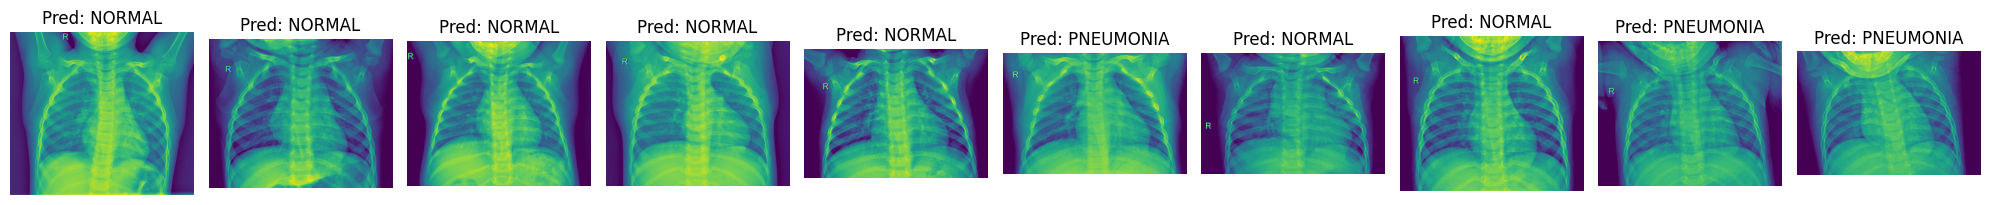

In [20]:
def display_images_with_predictions(generator, y_pred, num_images_to_display=10):
    # Get the class labels
    labels = {v: k for k, v in generator.class_indices.items()}

    # Get the filenames of the images
    filenames = generator.filenames

    # Create a subplot grid
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

    for i in range(num_images_to_display):
        # Construct image path
        image_path = os.path.join(generator.directory, filenames[i])
        image = plt.imread(image_path)

        # Get predicted label
        predicted_label_idx = int(y_pred[i])
        predicted_label = labels[predicted_label_idx]

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Pred: {predicted_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Call the function
display_images_with_predictions(train_generator, y_pred, num_images_to_display=10)